# GRC Stats Crawler

## Publications

Run the scripts in the `README.md` file to prepare the data first.

Then continue from the following to collect stats about the center.

In [1]:
import json

with open('publications.json', 'r', encoding='utf-8') as f:
    publications = json.load(f)

print(f"{len(publications)} publications found")

345 publications found


Initialize Crossref instance

In [2]:
from habanero import Crossref

cr = Crossref()

For every publication:

In [3]:
publications.reverse()

In [4]:
import requests
import serpapi
from string import digits
from thefuzz import fuzz


OC_API_KEY = ''
OC_CITE_COUNT_API = 'https://opencitations.net/index/coci/api/v1/citation-count/'
OC_HTTP_HEADERS = {'authorization': OC_API_KEY}
SERP_API_KEY = ''


remove_digits = str.maketrans('', '', digits)

for i, publication in enumerate(publications.copy()):

    # Set defaults
    publications[i]['doi'] = ''
    publications[i]['cite_count'] = 0
    publications[i]['cite_source'] = ''
    publications[i]['publisher'] = ''
    publications[i]['venue_acronym'] = ''
    publications[i]['venue_location'] = ''

    pub_type = publication['type']

    if pub_type in ['Conference', 'Workshop']:

        pub_title = publication['title']

        cr_works = cr.works(query=publication['title'], limit=1)
        
        if cr_works['message']['items']:

            cr_work = cr_works['message']['items'][0]

            cr_work_title = cr_work['title'][0]

            if fuzz.ratio(pub_title, cr_work_title) > 90:

                cr_work_cite_count = cr_work['is-referenced-by-count'] if 'is-referenced-by-count' in cr_work else 0
                cr_work_doi = cr_work['DOI']
                cr_work_publisher = cr_work['publisher'] if 'publisher' in cr_work else ''

                cr_work_venue_acronym = ''
                cr_work_venue_location = ''
                if 'event' in cr_work:
                    if 'acronym' in cr_work['event']:
                        cr_work_venue_acronym = (
                            cr_work['event']['acronym']
                            .translate(remove_digits)
                            .strip()
                            .rstrip("-")
                            .strip()
                            .rstrip("'")
                            .strip()
                        )
                    if 'location' in cr_work['event']:
                        cr_work_venue_location = cr_work['event']['location']

                oc_cite_count = 0
                # oc_response = requests.get(OC_CITE_COUNT_API + cr_work_doi, headers=OC_HTTP_HEADERS)
                # if oc_response.ok:
                #     oc_ref_arr = oc_response.json()
                #     if oc_ref_arr:
                #         oc_cite_count = int(oc_ref_arr[0]['count'])

                publications[i]['doi'] = cr_work_doi
                publications[i]['cite_count'] = max(cr_work_cite_count, oc_cite_count)
                publications[i]['cite_source'] = 'crossref'
                publications[i]['publisher'] = cr_work_publisher
                publications[i]['venue_acronym'] = cr_work_venue_acronym
                publications[i]['venue_location'] = cr_work_venue_location

        try:
            # go to google scholar only for publications with more than 1 citation due to api limit
            if publications[i]['cite_count'] > 1:
                gs_cite_count = 0
                gs_params = dict(
                    api_key=SERP_API_KEY,
                    engine="google_scholar",
                    num=1,
                    q=pub_title,
                )
                gs_results = serpapi.search(gs_params)
                if 'organic_results' in gs_results and len(gs_results['organic_results']) > 0:
                    gs_result = gs_results['organic_results'][0]
                    gs_title = gs_result['title']
                    
                    if fuzz.ratio(pub_title, gs_title) > 90:
                        gs_cite_count = gs_result['inline_links']['cited_by']['total']

                        # fix citation count
                        publications[i]['cite_count'] = max(publications[i]['cite_count'], gs_cite_count)
                        publications[i]['cite_source'] = 'google_scholar'
        except:
            # pass, probably api limit
            pass

        pub_cite_count = publications[i]['cite_count']
        pub_cite_source = publications[i]['cite_source']

        print(f"({i + 1}/{len(publications)})", pub_title, pub_cite_count, pub_cite_source)


(8/345) A Scalable Parallel Algorithm for Periodic Symmetric Toeplitz Tridiagonal Systems 0 
(9/345) Shared Virtual Memory and Generalized Speedup 14 google_scholar
(11/345) A Green's Function Approach to Distributed Solution of Tridiagonal Systems 0 
(12/345) A Massively Parallel Algorithm for Compact Finite Difference Schemes 0 crossref
(13/345) Performance Prediction of Scalable Computing: A case study 1 crossref
(17/345) Performance Considerations : A Case Study Using a Scalable Shared-Virtual-Memory Machines 0 
(18/345) The Relation of Scalability and Execution Time 24 google_scholar
(19/345) MpPVM: A Software System for Non-Dedicated Heterogeneous Computing 0 
(22/345) A Simulation Study of Packed Exponential Connection Network 0 
(23/345) Memory Space Representation for Heterogeneous Network Process Migration 17 google_scholar
(24/345) Performance Range Comparison Via Crossing Point Analysis 0 
(26/345) Communication Overhead: Prediction and Its Influence on Scalability 0 
(27/3

In [11]:
import re
from datetime import datetime

# publications.reverse()

for i, publication in enumerate(publications.copy()):

    pub_title = publication['title']
    pub_type = publication['type']
    pub_venue = publication['venue']
    pub_venue_acronym = publication['venue_acronym']

    publications[i]['month'] = 0
    publications[i]['year'] = 0
    pub_date = publication['date']
    if pub_date != 'TBA':
        pub_dt = datetime.strptime(pub_date, '%B, %Y')
        publications[i]['month'] = pub_dt.month
        publications[i]['year'] = pub_dt.year

    publications[i]['is_best_paper'] = False
    if pub_type in ['Conference', 'Journal', 'Workshop']:
        if re.search('best', pub_title, re.IGNORECASE) or \
            re.search('best', pub_venue, re.IGNORECASE):
            pub_tags = publication.get('tags', [])
            pub_tags.append('Best Paper Award')
            publications[i]['is_best_paper'] = True
            publications[i]['tags'] = pub_tags

    if pub_venue_acronym == '':
        pub_venue_matches = re.search(r'\((.*?)\)', pub_venue)
        if pub_venue_matches:
            pub_venue_acronym = (
                pub_venue_matches
                .group(1)
                .translate(remove_digits)
                .rstrip("-")
                .rstrip("'")
                .strip()
            )
            publications[i]['venue_acronym'] = pub_venue_acronym
    elif pub_venue_acronym.endswith("'"):
        publications[i]['venue_acronym'] = pub_venue_acronym.rstrip("'")

In [1]:
import pandas as pd

pub_df = pd.read_parquet('publications_enriched.parquet')
# pub_df = pd.DataFrame(publications)

# pub_df['month'] = pub_df['month'].astype(int)
# pub_df['year'] = pub_df['year'].astype(int)

print(f"{len(pub_df)} publications imported")

345 publications imported


In [2]:
(
    pub_df
    .sort_values('cite_count', ascending=False)
    .head(10)[['title', 'year', 'cite_count', 'is_best_paper']]
)

,title,year,cite_count,is_best_paper
216,Parallel I/O Prefetching Using MPI File Cachin...,2008,196,False
207,System Log Pre-processing to Improve Failure P...,2009,139,False
248,Exploit Failure Prediction for Adaptive Fault-...,2006,113,False
140,Integrating dynamic pricing of electricity int...,2013,107,False
178,Co-Analysis of RAS Log and Job Log on Blue Gene/P,2011,101,False
175,Practical Online Failure Prediction for Blue G...,2011,92,False
270,Improving the Performance of MPI Derived Datat...,2003,72,False
205,Reliability-Aware Scalability Models for High ...,2009,72,False
176,A Cost-intelligent Application-specific Data l...,2011,67,False
189,Optimizing HPC Fault-Tolerant Environment: An ...,2010,63,False


In [3]:
print(f"{len(pub_df[pub_df['doi'] != ''])}/{len(pub_df)} DOI found")

154/345 DOI found


In [4]:
pub_df['venue_acronym'].value_counts()

venue_acronym
            108
SC           33
IPDPS        20
Cluster      16
CCGrid       13
           ... 
Euro-Par      1
ICAPP         1
FGCS          1
ICAC          1
HICSS         1
Name: count, Length: 84, dtype: int64

In [5]:
pub_venues = pub_df[pub_df['venue_acronym'] != '']['venue_acronym'].value_counts()
pub_venues.head(10)

venue_acronym
SC         33
IPDPS      20
Cluster    16
CCGrid     13
ICPP       12
TPDS       11
HPDC        6
JCST        5
IPPS        5
ICS         4
Name: count, dtype: int64

<Axes: >

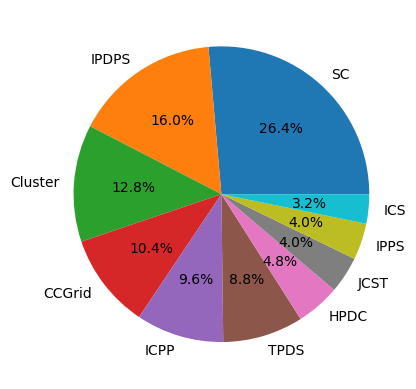

In [6]:
pub_venues.head(10).plot.pie(autopct='%1.1f%%', ylabel='')

In [7]:
pub_df['cite_count'].sum()

3054

<Axes: xlabel='year'>

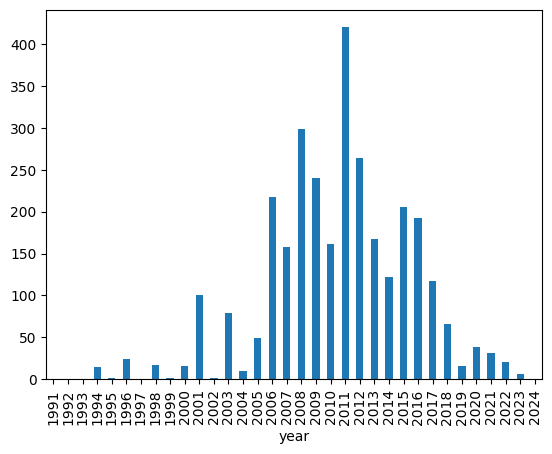

In [8]:
(
    pub_df
    .query('year > 0')
    .groupby('year')['cite_count']
    .sum()
    .plot.bar()
)

In [9]:
print(f"{len(pub_df[pub_df['is_best_paper'] == True])}/{len(pub_df)} best paper found")

4/345 best paper found


In [10]:
pub_df[pub_df['is_best_paper'] == True][['title', 'year', 'venue_acronym', 'type', 'cite_count']]

,title,year,venue_acronym,type,cite_count
32,DLIO: A Data-Centric Benchmark for Scientific ...,2021,CCGrid,Conference,12
56,LABIOS: A Distributed Label-Based I/O System,2019,HPDC,Conference,0
215,Hiding I/O Latency with Pre-execution Prefetch...,2008,SC,Conference,0
292,Communication State Transfer for the Mobility ...,2001,ICPP,Conference,25


In [12]:
pub_df[['title', 'year', 'venue_acronym', 'type', 'cite_count']].to_csv('publications_enriched.csv')

In [24]:
pub_df.to_json('publications_enriched.json', orient='records')
pub_df.to_parquet('publications_enriched.parquet')

## Members

In [78]:
import pandas as pd
from bs4 import BeautifulSoup

mem_url = 'https://grc.iit.edu/members'

alum_df = pd.read_html(mem_url)[0]
alum_df.columns = map(lambda x: x.lower().replace(' / ', ' ').replace(' ', '_'), alum_df.columns)

print(f"{len(alum_df)} alumni imported")

60 alumni imported


<Axes: >

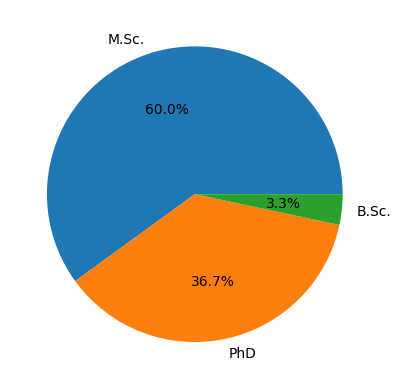

In [121]:
alum_degrees = alum_df['degree'].value_counts()
alum_degrees.plot.pie(autopct='%1.1f%%', ylabel='')

## Classes

In [147]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

class_url = 'http://www.cs.iit.edu/~scs/sun/classes.html'

class_res = requests.get(class_url)
class_html = BeautifulSoup(class_res.text, 'html.parser')

class_list = []

for li in class_html.find('ul').findAll('li'):
    
    class_full = li.text.strip().replace('  ', ' ').strip()

    class_code = class_full[:class_full.index('(')].strip()
    class_name = class_full[class_full.index('(') + 1:class_full.index(')')].strip()
    
    class_num = class_code[class_code.index(' ') + 1:].strip()
    class_level = 'Graduate'
    if any(class_num.startswith(prefix) for prefix in ['2', '3', '4']):
        class_level = 'Undergraduate'

    class_list.append(dict(
        class_code=class_code,
        class_name=class_name,
        class_level=class_level,
    ))

print(f"{len(class_list)} classes imported")

24 classes imported


In [148]:
class_df = pd.DataFrame(class_list)
class_df.sample(3)

,class_code,class_name,class_level
18,CSC 7450,Programming and Performance Evaluation of Para...,Graduate
4,CS 450,Operating Systems,Undergraduate
6,CSC 4999,"Independent Study, LSU",Undergraduate


<Axes: >

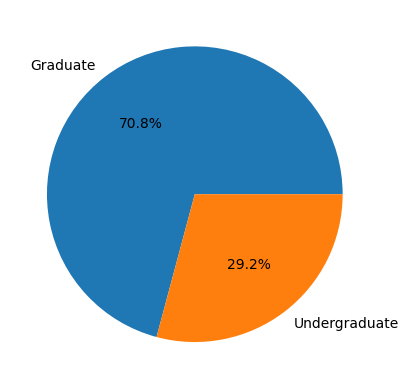

In [150]:
class_df['class_level'].value_counts().plot.pie(autopct='%1.1f%%', ylabel='')